In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import image
from skimage import transform, exposure
from sklearn.model_selection import train_test_split

from torchvision import transforms

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


import time

import random
from PIL import Image
import cv2

In [2]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)

In [3]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
5431,HAM_0002355,ISIC_0029202,bkl,consensus,35,male,abdomen,False,HAM10000_images_part_1/bkl/ISIC_0029202.jpg,0
19958,HAM_0004820,ISIC_0030722,vasc,consensus,45,female,abdomen,False,HAM10000_images_part_2/vasc/ISIC_0030722.jpg,4
20965,HAM_0006447,ISIC_0031276,vasc,consensus,75,male,abdomen,False,HAM10000_images_part_2/vasc/ISIC_0031276.jpg,4
7366,HAM_0000582,ISIC_0025885,bkl,histo,85,male,lower extremity,False,HAM10000_images_part_1/bkl/ISIC_0025885.jpg,0
18771,HAM_0004413,ISIC_0026068,vasc,consensus,55,female,abdomen,False,HAM10000_images_part_1/vasc/ISIC_0026068.jpg,4


In [4]:
data.shape

(30905, 10)

In [5]:
def transormations_apply(img_path,img_h, img_w, norm_means, norm_std):
    """
    Create a transformation pipeline and apply it to an image.
    The image is loaded from the given path and the transformation is applied.
    The result is returned as a NumPy array.

    Parameters:
    img_path (str): The path to the image file.
    img_h (int): The height to resize the images to.
    img_w (int): The width to resize the images to.
    norm_means (tuple): The means for each channel used for normalization.
    norm_std (tuple): The standard deviations for each channel used for normalization.

    Returns:
    numpy.ndarray: The transformed image as a NumPy array.
    """
    transform = transforms.Compose([
        transforms.Resize((img_h, img_w)), # we applied resize for memory reasons
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(norm_means, norm_std),
        transforms.Lambda(lambda x: x.numpy())  # convert the tensor to a NumPy array
    ])

    image = Image.open(img_path).convert('RGB')  

    transformed_image = transform(image)

    return transformed_image


In [6]:
# use the same mean and std as before
norm_means = np.array([0.77148203, 0.55764165, 0.58345652])
norm_std =  np.array([0.12655577, 0.14245141, 0.15189891])
img_h, img_w = 224, 224

## Sample for feature importance

In [7]:
selected_data = data.groupby('dx').apply(lambda x: x.sample(n=500)).reset_index(drop=True)
selected_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
0,HAM_0001453,ISIC_0030991,akiec,histo,45,male,face,False,HAM10000_images_part_2/akiec/ISIC_0030991.jpg,6
1,HAM_0001048,ISIC_0026525,akiec,histo,45,male,face,False,HAM10000_images_part_1/akiec/ISIC_0026525.jpg,6
2,HAM_0005301,ISIC_0026362,akiec,histo,60,female,upper extremity,False,HAM10000_images_part_1/akiec/ISIC_0026362.jpg,6
3,HAM_0002061,ISIC_0030408,akiec,histo,80,male,scalp,False,HAM10000_images_part_2/akiec/ISIC_0030408.jpg,6
4,HAM_0005438,ISIC_0027708,akiec,histo,50,female,face,False,HAM10000_images_part_1/akiec/ISIC_0027708.jpg,6
...,...,...,...,...,...,...,...,...,...,...
3495,HAM_0004549,ISIC_0031201,vasc,consensus,45,male,trunk,False,HAM10000_images_part_2/vasc/ISIC_0031201.jpg,4
3496,HAM_0000286,ISIC_0029099,vasc,consensus,70,female,abdomen,False,HAM10000_images_part_1/vasc/ISIC_0029099.jpg,4
3497,HAM_0000286,ISIC_0029099,vasc,consensus,70,female,abdomen,False,HAM10000_images_part_1/vasc/ISIC_0029099.jpg,4
3498,HAM_0003829,ISIC_0026349,vasc,consensus,60,female,trunk,False,HAM10000_images_part_1/vasc/ISIC_0026349.jpg,4


## **Feature Extraction**

In order to make sence to use the sklearn library with the classic classifiers we need to handle the high resolution of 30000 images. So we need a feature extraction method that is applicable in images. The HOG method is capturing the image shapes using gradients although in our dataset the color is a crutial parameter that we need to keep. PCA is another way to reduce the dataset components although we tried it and it is very slow and also consumes much memory. So we will try the Scale-Invariant Feature Transform method in order to detect keypoints of the images and use them for the classification. 

# PCA

## Dimentionality reduction using PCA

In [8]:
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor

In [9]:
flattened_images = []
def process_image(img_path):
    transformed_image = transormations_apply(img_path, img_h, img_w, norm_means, norm_std)
    return transformed_image.flatten()

with ThreadPoolExecutor(max_workers=16) as executor:
    all_flatten_images = list(tqdm(executor.map(process_image, selected_data['image_path']), total=len(selected_data)))

X = np.array(all_flatten_images)

  0%|          | 0/3500 [00:00<?, ?it/s]

100%|██████████| 3500/3500 [00:10<00:00, 326.19it/s]


In [10]:
pca = PCA(n_components=200) # 200 is a random high number of components
# Number of components explaining 95% of the variance: 135
pca.fit(X)

explained_variance = pca.explained_variance_ratio_

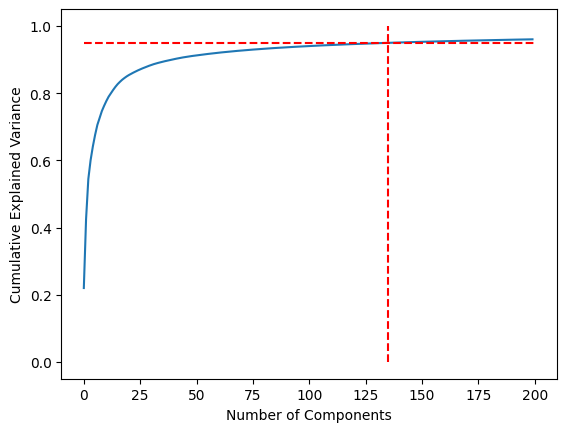

Number of components explaining 95% of the variance: 138


In [11]:
cumulative_variance = np.cumsum(explained_variance)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(0.95, 0, 200, color='r', linestyle='--')
plt.vlines(135, 0, 1, color='r', linestyle='--')
plt.show()

# Select the number of components that explain, say, 95% of the variance
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
print(f"Number of components explaining 95% of the variance: {n_components_95}")

In [12]:
del(pca,X)

This took approximately 20 minutes and filled up a big part of RAM memory with only 3500 images. Thus we decided to try another way.

In [13]:
def process_batch(image_paths, img_h, img_w, norm_means, norm_std):
    with ThreadPoolExecutor(max_workers=16) as executor:
        flattened_images = list(tqdm(executor.map(lambda img_path: transormations_apply(img_path, img_h, img_w, norm_means, norm_std).flatten(), image_paths), total=len(image_paths)))
    return np.array(flattened_images)


from sklearn.decomposition import IncrementalPCA

n_components = 135
ipca = IncrementalPCA(n_components=n_components)

batch_size = 2000  

for i in range(0, len(data['image_path']), batch_size):
    batch_paths = data['image_path'][i:i + batch_size]
    X_batch = process_batch(batch_paths, img_h, img_w, norm_means, norm_std)
    ipca.partial_fit(X_batch)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 905/905 [00:03<00:00, 285.01it/s]


23 minutes

In [14]:
from joblib import dump

dump(ipca, 'ipca_model.joblib')

['ipca_model.joblib']

In [15]:
from joblib import load
ipca = load('ipca_model.joblib')

In [18]:
ipca.components_.shape

(135, 150528)

We stoped it here because it filled 32gb RAM memory

# Scale-Invariant Feature Transform

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['image_path'], data['dx_cat'], test_size=0.3)

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
# clf = SGDClassifier()

In [9]:
clf_SGD = SGDClassifier()
# clf_MNB = MultinomialNB()
clf_Perceptron = Perceptron()
clf_PAC = PassiveAggressiveClassifier()
clf_MLP = MLPClassifier()

In [10]:
# def process_images_in_batches(X, y, batch_size):
#     for i in range(0, len(X), batch_size):
#         batch = X.iloc[i:i + batch_size]
#         images = []
#         labels = []

#         for _, row in batch.iterrows():
#             img_path = row['image_path']
#             label = row.get('dx_cat', None)  

#             transformed_image = transormations_apply(img_path, img_h, img_w, norm_means, norm_std)
#             images.append(transformed_image)

#             if label is not None:
#                 labels.append(label)

#         yield np.array(images), np.array(labels)

In [11]:
def process_images_in_batches(X, y, batch_size):
    """
    Process images in batches.

    Parameters:
    X (iterable): Iterable containing image paths.
    y (iterable): Iterable containing labels corresponding to image paths.
    batch_size (int): The number of images to process in each batch.

    Yields:
    tuple: A batch of transformed images and their corresponding labels as NumPy arrays.
    """
    n_batches = len(X) // batch_size + (1 if len(X) % batch_size else 0)

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_images = X[start_idx:end_idx]
        batch_labels = y[start_idx:end_idx]

        images = []
        labels = []

        for img_path, label in zip(batch_images, batch_labels):
            transformed_image = transormations_apply(img_path, img_h, img_w, norm_means, norm_std)
            images.append(transformed_image)
            labels.append(label)

        yield np.array(images), np.array(labels)

In [12]:
batch_size = 2500  
total_batches = len(X_train) // batch_size + (0 if len(X_train) % batch_size == 0 else 1)

for images_batch, labels_batch in tqdm(process_images_in_batches(X_train, y_train, batch_size), total=total_batches):
    images_batch_reshaped = images_batch.reshape(images_batch.shape[0], -1)
    
    clf_SGD.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(y_train))
    # clf_MNB.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(y_train))
    clf_Perceptron.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(y_train))
    clf_PAC.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(y_train))
    clf_MLP.partial_fit(images_batch_reshaped, labels_batch, classes=np.unique(y_train))

100%|██████████| 9/9 [05:42<00:00, 38.01s/it]


In [13]:
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Assuming X_test and y_test are your test set features and labels

batch_size = 2500
total_batches = len(X_test) // batch_size + (0 if len(X_test) % batch_size == 0 else 1)

# Initialize empty lists to collect the true labels and predicted labels for each classifier
true_labels = []
predictions_SGD = []
# predictions_MNB = []  # Uncomment if using MultinomialNB or any other classifier
predictions_Perceptron = []
predictions_PAC = []
predictions_MLP = []

for images_batch, labels_batch in tqdm(process_images_in_batches(X_test, y_test, batch_size), total=total_batches):
    images_batch_reshaped = images_batch.reshape(images_batch.shape[0], -1)
    
    # Store true labels
    true_labels.extend(labels_batch)
    
    # Predict with each classifier and store predictions
    predictions_SGD.extend(clf_SGD.predict(images_batch_reshaped))
    # predictions_MNB.extend(clf_MNB.predict(images_batch_reshaped))  # Uncomment if applicable
    predictions_Perceptron.extend(clf_Perceptron.predict(images_batch_reshaped))
    predictions_PAC.extend(clf_PAC.predict(images_batch_reshaped))
    predictions_MLP.extend(clf_MLP.predict(images_batch_reshaped))

# Now, calculate and print the accuracy for each classifier
print("SGD Classifier Accuracy:", accuracy_score(true_labels, predictions_SGD))
# print("MultinomialNB Classifier Accuracy:", accuracy_score(true_labels, predictions_MNB))  # Uncomment if applicable
print("Perceptron Classifier Accuracy:", accuracy_score(true_labels, predictions_Perceptron))
print("Passive Aggressive Classifier Accuracy:", accuracy_score(true_labels, predictions_PAC))
print("MLP Classifier Accuracy:", accuracy_score(true_labels, predictions_MLP))

# Optionally, print a classification report for more detailed performance analysis
print("\nClassification Report for SGD Classifier:\n", classification_report(true_labels, predictions_SGD))
# print("\nClassification Report for MultinomialNB Classifier:\n", classification_report(true_labels, predictions_MNB))  # Uncomment if applicable
print("\nClassification Report for Perceptron Classifier:\n", classification_report(true_labels, predictions_Perceptron))
print("\nClassification Report for Passive Aggressive Classifier:\n", classification_report(true_labels, predictions_PAC))
print("\nClassification Report for MLP Classifier:\n", classification_report(true_labels, predictions_MLP))


100%|██████████| 4/4 [02:00<00:00, 30.12s/it]

SGD Classifier Accuracy: 0.34156600517687663
Perceptron Classifier Accuracy: 0.3285159620362381
Passive Aggressive Classifier Accuracy: 0.386755823986195
MLP Classifier Accuracy: 0.15929680759275236

Classification Report for SGD Classifier:
               precision    recall  f1-score   support

           0       0.17      0.47      0.25      1311
           1       0.43      0.56      0.49      1359
           2       0.57      0.25      0.35      1348
           3       0.32      0.42      0.36      1281
           4       0.73      0.40      0.52      1313
           5       0.47      0.12      0.19      1340
           6       0.42      0.17      0.24      1320

    accuracy                           0.34      9272
   macro avg       0.44      0.34      0.34      9272
weighted avg       0.45      0.34      0.34      9272


Classification Report for Perceptron Classifier:
               precision    recall  f1-score   support

           0       0.20      0.50      0.28      1311
